In [1]:
import warnings

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
import plotly.offline as pof
from sklearn.preprocessing import LabelEncoder

pof.init_notebook_mode()
pio.renderers.default = "png"


def set_up_printing():
    """Sets up display parameters"""

    max_dimensions_display_limit = 1000
    pd.set_option('display.max_columns', max_dimensions_display_limit)
    pd.set_option('display.max_colwidth', None)

    pd.set_option('display.max_rows', max_dimensions_display_limit)
    pd.set_option('display.width', None)

    pd.set_option('display.max_info_columns', max_dimensions_display_limit)
    pd.set_option('display.max_info_rows', max_dimensions_display_limit)

    warnings.filterwarnings('ignore')


def missing_percent(data, total):
    """Gets missing percent"""
    return data.isnull().sum() / total * 100


def fix_nan_values(dataframe, protected_columns, limit, to_remove):
    """Clears nan values"""
    print(dataframe.isnull().sum())

    for column in dataframe.columns:
        percent = missing_percent(dataframe[column], dataframe.shape[0])

        # сравниваем с пороговым значением заданным экспертно
        if limit > percent > 0:
            print(
                'Строки, содержащие пустые значения в столбце ' + column + ' будут удалены:')
            print('- всего обнаружено NaN пустых значений, в процентах от всего набора:', round(percent, 2), '%')

            if (to_remove):
                dataframe = dataframe[dataframe[column].notna()]

        if percent >= limit:
            if column not in protected_columns:
                print('Столбец ' + column + ' будет удален, значительное число Nan значений:')
                print('- всего было NaN значений, в процентах от всего набора:', round(percent, 2), '%')

            if (to_remove):
                dataframe = dataframe.drop(column, errors='ignore', axis=1)
            else:
                print(
                    'Строки, содержащие пустые значения в обязательном для сохранения столбце ' + column + ' будут удалены:')
                print('- всего обнаружено NaN пустых значений, в процентах от всего набора:', round(percent, 2), '%')
                if (to_remove):
                    dataframe = dataframe[dataframe[column].notna()]

    print('\n')

    return dataframe


def clear(dataframe, protected_columns, is_initial_analysis=False, clear_nan=False):
    """
    Clears dataframe.

    :param dataframe: dataframe
    :param protected_columns: protected columns - doesn't removes it
    :param is_initial_analysis: just drops duplicates for the initial processing
    :param clear_nan: to clear nan or not
    :return:
    """
    analysis_type = ''
    if is_initial_analysis:
        analysis_type = 'очистки первичного датасета'
    else:
        analysis_type = 'очистки основного датасета'

    target_balance(dataframe, 'Баланс целевого признака до очистки в процессе ' + analysis_type + ':')

    info_aux_and_nans(dataframe, 'До очистки от NaN значений в процессе ' + analysis_type + ':')
    if is_initial_analysis:
        shape(dataframe, 'До очистки от дубликатов в процессе ' + analysis_type + ':')
        dataframe = dataframe.drop_duplicates()
        shape(dataframe, 'После очистки от дубликатов в процессе ' + analysis_type + ':')
        return dataframe

    if clear_nan:
        dataframe = fix_nan_values(dataframe, protected_columns, 2, True)
        info_aux_and_nans(dataframe, 'После очистки от NaN значений в процессе ' + analysis_type + ':')

    shape(dataframe, 'До очистки от дубликатов в процессе ' + analysis_type + ':')
    dataframe = dataframe.drop_duplicates()
    shape(dataframe, 'После очистки от дубликатов в процессе ' + analysis_type + ':')

    print('Дубликатов рядов в наборе для тренировки - не найдено.', '\n')

    info_aux(dataframe, 'До очистки от низкоинформативных столбцов в процессе ' + analysis_type + ':')
    dataframe = drop_low_informative(dataframe, protected_columns)
    info_aux(dataframe, 'После очистки от низкоинформативных столбцов в процессе ' + analysis_type + ':')

    target_balance(dataframe, 'Баланс целевого признака после очистки ' + analysis_type + ':')

    print('\n')

    return dataframe


def drop_low_informative(dataframe, protected_columns):
    """Drops low informative"""
    low_information_cols = get_low_informative(dataframe, 0.95)

    print(
        'Исходя из содержания столбцов, мы можем удалить столбцы listing_url, thumbnail_url, medium_url, xl_picture_url, country_code, country, has_availability',
        '\n')
    print(
        'Оставим столбцы, которые могут быть полезны при глубоком анализе, например, может пригодиться name хоста в случае'
        ' парсинга пользователями набора данных столбцов summary или house_rules, а picture_url может пригодиться'
        ' для понимания, есть ли вообще картинка у предложения.')
    dataframe = dataframe.drop(
        ['listing_url', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'country_code', 'country',
         'has_availability', 'host_thumbnail_url'],
        errors='ignore',
        axis=1)
    return dataframe


def get_low_informative(dataframe, limit):
    """Gets low informative columns"""
    low_information_cols = []

    for col in dataframe.columns:
        # наибольшая относительная частота значения признака
        top_freq = dataframe[col].value_counts(normalize=True).max()
        # доля уникальных значений признака
        nunique_ratio = dataframe[col].nunique() / dataframe[col].count()
        # сравниваем с пороговым значением заданным экспертно
        if top_freq > limit:
            print(f'{col}: {round(top_freq * 100, 2)}% одинаковых значений')
            low_information_cols.append(col)
        # сравниваем долю уникальных значений с порогом
        if nunique_ratio > limit:
            print(f'{col}: {round(nunique_ratio * 100, 2)}% уникальных значений')
            low_information_cols.append(col)

    return low_information_cols


def info_aux(dataframe, message):
    """Prints dataframe info"""
    print(message, '\n')
    dataframe.info()
    print('\n')


def info_aux_and_nans(dataframe, message):
    """Prints dataframe info and shows nan stats"""
    print(message, '\n')
    dataframe.info()
    dataframe.isnull().sum()
    print('\n')


def shape(dataframe, message):
    """Prints dataframe shape"""
    print(message, '\n')
    print(' - размерность набора данных - ', dataframe.shape)
    print('\n')


def info_aux_and_head(dataframe, message):
    """Prints dataframe info plas prints first 3 lines"""
    print(message, '\n')
    dataframe.info()
    print(dataframe.head(3))
    print('\n')


def target_balance(dataframe, message):
    """Paints current target histograms"""
    print(message, '\n')
    print('Количество уникальных значений целевого признака: ', len(dataframe['price'].value_counts().tolist()))
    histogram = px.histogram(data_frame=dataframe, x='price', title='price distribution', marginal='box')
    histogram.show('png')
    print('\n')


def one_to_one_transforms(dataframe, is_initial_analysis=False, is_minimum_transform=False):
    """Transforms column values for each column by condition."""
    dataframe['cleaning_fee'] = dataframe['cleaning_fee'].dropna().apply(
        lambda x: str(x).replace('$', '').replace('.00', '').replace(',', '.')).apply(pd.to_numeric)
    dataframe['security_deposit'] = dataframe['security_deposit'].dropna().apply(
        lambda x: str(x).replace('$', '').replace('.00', '').replace(',', '.')).apply(pd.to_numeric)
    dataframe['extra_people'] = dataframe['extra_people'].dropna().apply(
        lambda x: str(x).replace('$', '').replace('.00', '').replace(',', '.')).apply(pd.to_numeric)

    dataframe['zipcode'] = dataframe['zipcode'].apply(lambda x: str(x))

    dataframe['amenities'] = dataframe['amenities'].apply(lambda x: len(x.split(',')))
    dataframe['picture_url'] = dataframe['picture_url'].fillna(0).apply(lambda x: 0 if x == 0 else 1)
    dataframe['host_picture_url'] = dataframe['host_picture_url'].fillna(0).apply(lambda x: 0 if x == 0 else 1)

    dataframe[['last_scraped', 'first_review', 'last_review']] = dataframe[
        ['last_scraped', 'first_review', 'last_review']].apply(pd.to_datetime)

    if is_minimum_transform:
        # пропускаем преобразования качественных признаков, поскольку итоговый датасет проще будет воспринимать пользователям
        # и само преобразование может быть другим, в зависисмости от задачи
        return dataframe

    dataframe['listing_url'] = dataframe['listing_url'].fillna(0).apply(lambda x: 0 if x == 0 else 1)
    dataframe[['calendar_last_scraped', 'host_since']] = dataframe[['calendar_last_scraped', 'host_since']].apply(
        pd.to_datetime)
    dataframe[['calendar_last_scraped', 'last_scraped', 'first_review', 'last_review', 'host_since']] = dataframe[
        ['calendar_last_scraped', 'last_scraped', 'first_review', 'last_review', 'host_since']].apply(pd.to_numeric)

    # by quality
    dataframe['host_response_time'] = dataframe['host_response_time'].replace(
        {'a few days or more': 1, 'within a day': 2,
         'within a few hours': 3, 'within an hour': 4})
    dataframe['room_type'] = dataframe['room_type'].replace(
        {'Shared room': 1, 'Private room': 2, 'Hotel room': 3, 'Entire home/apt': 4})
    dataframe['bed_type'] = dataframe['bed_type'].replace(
        {'Airbed': 1, 'Couch': 2, 'Futon': 3, 'Pull-out Sofa': 4, 'Real Bed': 5})
    dataframe['cancellation_policy'] = dataframe['cancellation_policy'].replace(
        {'flexible': 1, 'long_term': 2, 'moderate': 3, 'strict': 4,
         'strict_14_with_grace_period': 5, 'super_strict_30': 6,
         'super_strict_60': 7})

    dataframe['host_response_rate'] = dataframe['host_response_rate'].dropna().apply(
        lambda x: str(x).replace('%', '')).apply(pd.to_numeric)

    object_type_column_names = list(dataframe.select_dtypes(include=['object']).columns)

    manual_transforms = []
    object_type_column_names = [i for i in object_type_column_names if i not in manual_transforms]

    for name in object_type_column_names:
        # проанализируем описательну статистику по столбцам

        if is_initial_analysis:
            counts_len = len(dataframe[name].value_counts())
            if (counts_len <= 2 or counts_len > 7):
                print('Преобразуем значения столбца ' + name + ' в порядковые значения.', '\n')
                dataframe[name] = LabelEncoder().fit_transform(dataframe[name])
            else:
                print('Преобразуем значения столбца ' + name + ' методом one-hot encoding.', '\n')
                dataframe = pd.get_dummies(dataframe, columns=[name], prefix=name)
        else:
            # преобразуем качественные признаки в количественные
            counts_len = len(dataframe[name].value_counts())
            if (counts_len <= 2 or counts_len > 10):
                # лишь в случае двух или же относительно большого числа столбцов - заменим качественнее значения порядком (числом)
                # лучше не использовать в противном случае, посклольку модель может увидеть и оценить транзитивные зависимости между порядками

                print('Преобразуем значения столбца ' + name + ' в порядковые значения.', '\n')
                dataframe[name] = LabelEncoder().fit_transform(dataframe[name])
            else:

                print('Преобразуем значения столбца ' + name + ' методом one-hot encoding.', '\n')
                dataframe = pd.get_dummies(dataframe, columns=[name], prefix=name)

    info_aux_and_head(dataframe, 'После преобразования качественных и bool в количественные:')

    return dataframe


def correlation_matrix_analysis(dataframe, protected_columns):
    """Does correlation analysis and filter features."""

    print('Измерения набора данных до корреляционного анализа', dataframe.shape, '\n')
    target = dataframe.pop('price')
    dataframe.insert(0, 'price', target)

    corr = dataframe.corr()
    sorted_correlation_matrix = corr.unstack().sort_values(kind="quicksort", ascending=False)

    critical_cross_correlation = 0.95

    cross_correlated_features = sorted_correlation_matrix[
        (sorted_correlation_matrix > critical_cross_correlation) & (sorted_correlation_matrix < 1)].index.tolist()
    to_extend = [i for i in sorted_correlation_matrix[
        (sorted_correlation_matrix < -critical_cross_correlation)
        & (sorted_correlation_matrix > -1)].index.tolist() if i not in cross_correlated_features]

    cross_correlated_features.extend(to_extend)
    features_to_drop = [i[1] for i in cross_correlated_features if i != 'price']

    print('Сильно скоррелированные признаки: ' + str(cross_correlated_features))

    if (features_to_drop.__len__() > 0):
        sorted_correlation_matrix_with_price_column = sorted_correlation_matrix[
            ['price' in i for i in sorted_correlation_matrix.index]]
        i = 0
        while i < features_to_drop.__len__():
            one = features_to_drop[i]
            another = features_to_drop[i + 1]
            if one in protected_columns or another in protected_columns:
                if one not in protected_columns:
                    del features_to_drop[i + 1]
                elif another not in protected_columns:
                    del features_to_drop[i]
                else:
                    del features_to_drop[i]
                    del features_to_drop[i]
                    continue
            else:
                if abs(sorted_correlation_matrix_with_price_column[(one, 'price')]) > abs(
                        sorted_correlation_matrix_with_price_column[(another, 'price')]):
                    del features_to_drop[i + 1]
                else:
                    del features_to_drop[i]
            i = i + 1

        features_to_drop = list(set(features_to_drop))
        print('Признаки для рассмотрения на удаление, кросс-корреляция выше', critical_cross_correlation, ':', '\n',
              features_to_drop,
              '\n')

    # удалим менее скоррелированный с целевым признаком
    dataframe = dataframe.drop(features_to_drop, errors='ignore', axis=1)

    sorted_correlation_matrix_with_price_column = sorted_correlation_matrix[
        ['price' in i for i in sorted_correlation_matrix.index]]
    print('Результат корреляционного анализа фичей с целевым признаком:', '\n')
    print(sorted_correlation_matrix_with_price_column)

    print('Измерения набора данных после корреляционного анализа:', dataframe.shape, '\n')
    return dataframe, features_to_drop


def one_to_many_transform(dataframe, is_initial_analysis=False):
    aux = dataframe[dataframe[
        ['price', 'number_of_reviews', 'first_review', 'last_review', 'minimum_nights']].notnull().all(1)][
        ['price', 'number_of_reviews', 'first_review', 'last_review', 'minimum_nights']]
    prognosed_occupancy_days_per_year = (aux['number_of_reviews'] / 0.72 * aux['minimum_nights']) / (
        (pd.to_datetime(aux['last_review']) - pd.to_datetime(aux['first_review'])).dt.days) * 365
    prognosed_occupancy_days_per_year = prognosed_occupancy_days_per_year.replace([np.inf, -np.inf], np.nan)[
        (prognosed_occupancy_days_per_year.notnull()) & (prognosed_occupancy_days_per_year < 365)]
    dataframe['prognosed_occupancy_days_per_year'] = prognosed_occupancy_days_per_year
    dataframe['prognosed_income_per_year'] = dataframe['prognosed_occupancy_days_per_year'] * dataframe['price']
    
    dataframe_name = ''
    if is_initial_analysis == True:
        dataframe_name = 'датафрейма используемого в разведочном анализе'
    else:
        dataframe_name = 'исходного датафрейма'

    info_aux(dataframe, 'После генерации нового признака для ' + dataframe_name + ':')
    return dataframe


def draw_scatter(dataframe, x, y, color_column_name):
    df = dataframe[dataframe[[x, y]].notna().all(1)]
    scatter = px.scatter(data_frame=df, x=x, y=y, color=color_column_name,
                         title=x + ' vs ' + y + ' colored by ' + color_column_name,
                         marginal_y="histogram", marginal_x="histogram")
    scatter.show('png')


def draw_scatter_plots_for_target(dataframe, features, targets, color_column_name):
    for target in targets:
        for feature in [i for i in features if i != target]:
            draw_scatter(dataframe, feature, target, color_column_name)


def draw_visualization(dataframe, features, targets, color_by_column):
    draw_scatter_plots_for_target(dataframe, features, targets, color_by_column)
    draw_corr_matrix(dataframe, features)


def draw_corr_matrix(dataframe, features):
    corr = dataframe[features].corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    corr = corr.mask(mask)
    fig = ff.create_annotated_heatmap(
        z=corr.to_numpy().round(2),
        x=list(corr.index.values),
        y=list(corr.columns.values),
        xgap=3, ygap=3,
        zmin=-1, zmax=1,
        colorscale='Plotly3',
        colorbar_thickness=30,
        colorbar_ticklen=3,
        showscale=True
    )
    fig.update_layout(title_text='<b>Correlation Matrix<b>',
                      title_x=0.5,
                      titlefont={'size': 24},
                      width=1024, height=1024,
                      xaxis_showgrid=False,
                      xaxis={'side': 'bottom'},
                      yaxis_showgrid=False,
                      )
    fig.show('png')

Баланс целевого признака до очистки в процессе очистки первичного датасета: 

Количество уникальных значений целевого признака:  654


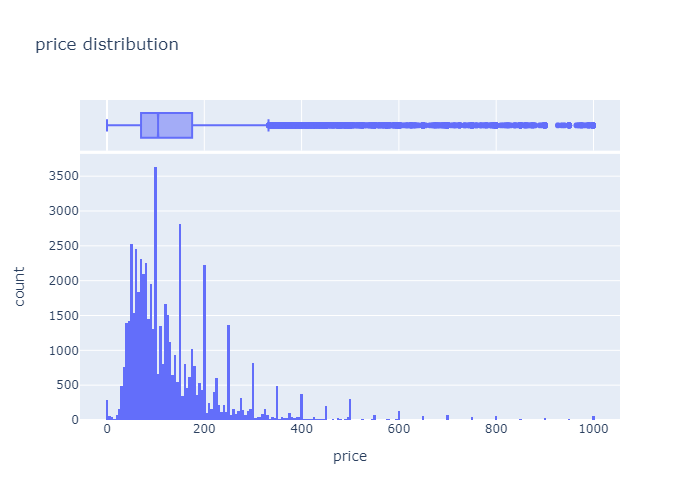



До очистки от NaN значений в процессе очистки первичного датасета: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56585 entries, 0 to 56584
Data columns (total 106 columns):
 #    Column                                        Dtype  
---   ------                                        -----  
 0    id                                            int64  
 1    listing_url                                   object 
 2    scrape_id                                     int64  
 3    last_scraped                                  object 
 4    name                                          object 
 5    summary                                       object 
 6    space                                         object 
 7    description                                   object 
 8    experiences_offered                           object 
 9    neighborhood_overview                         object 
 10   notes                                         object 
 11   transit                          

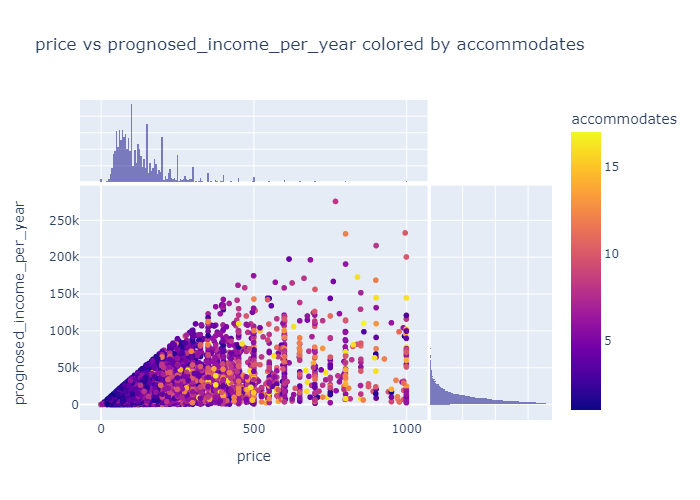

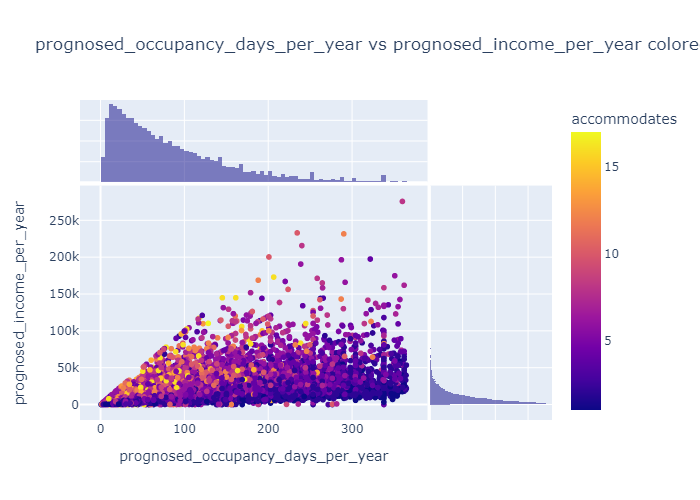

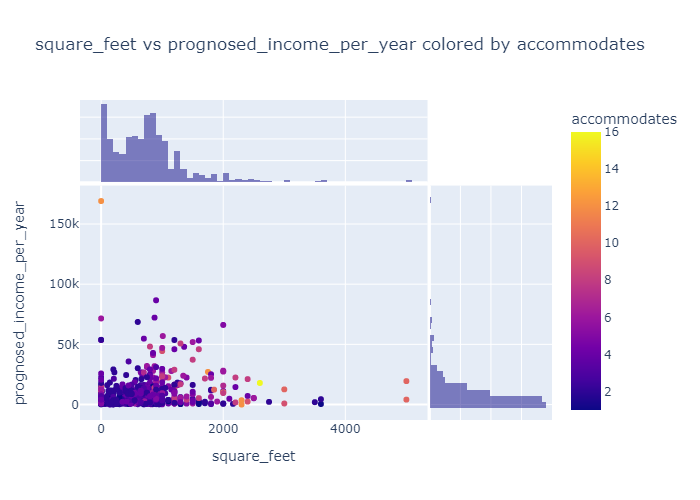

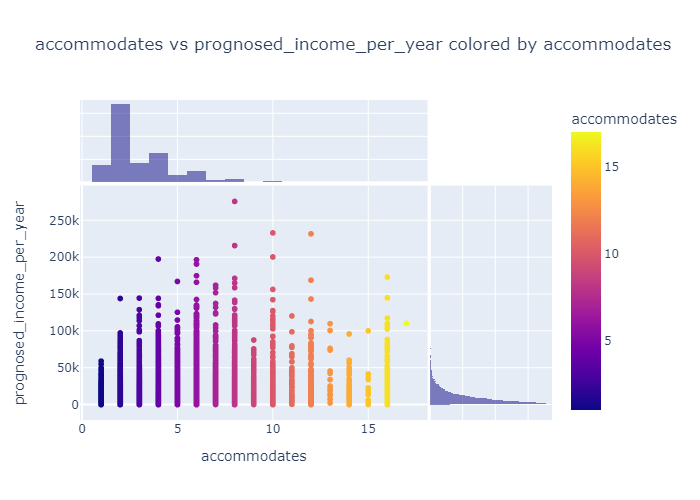

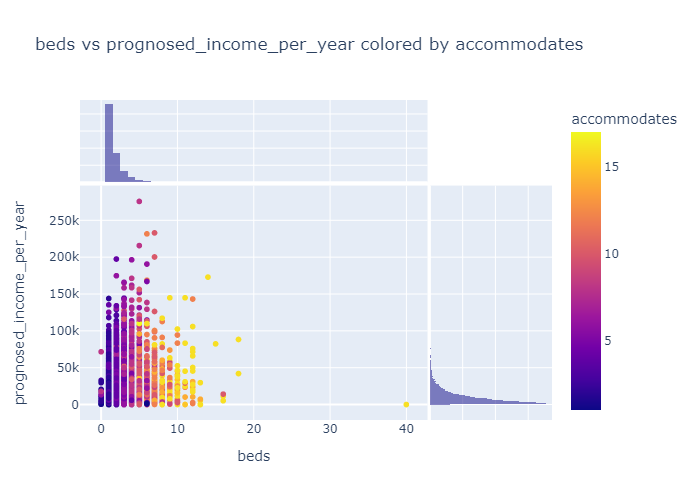

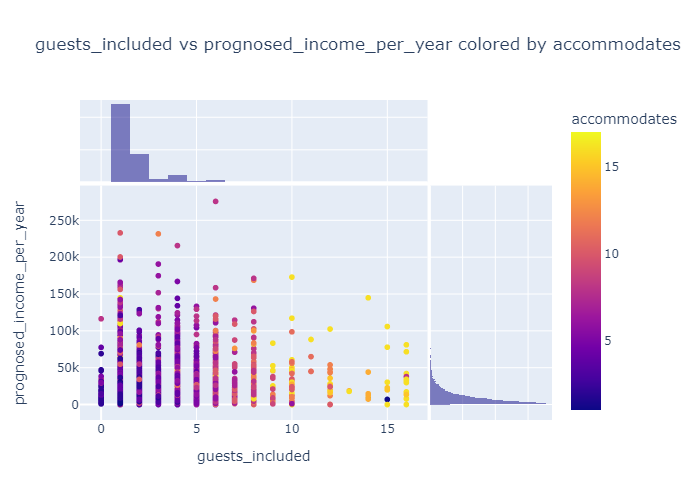

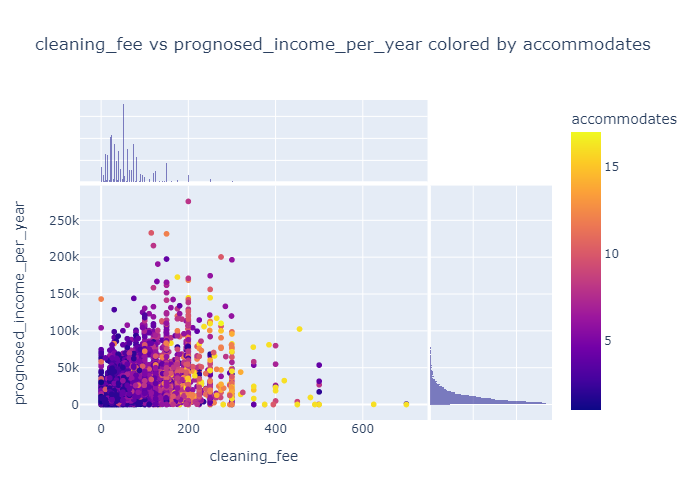

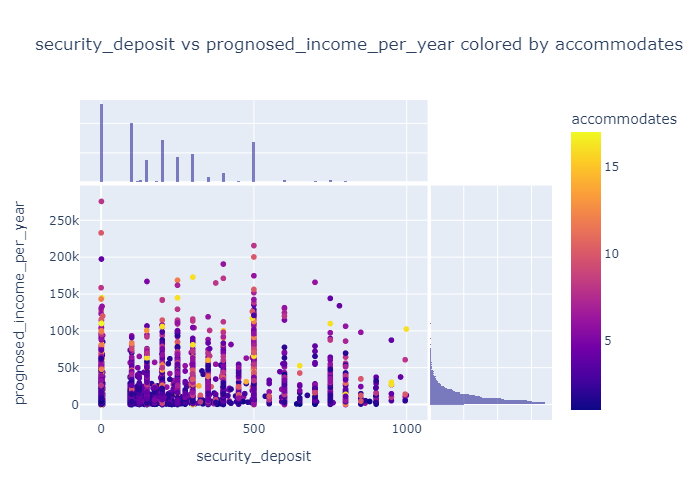

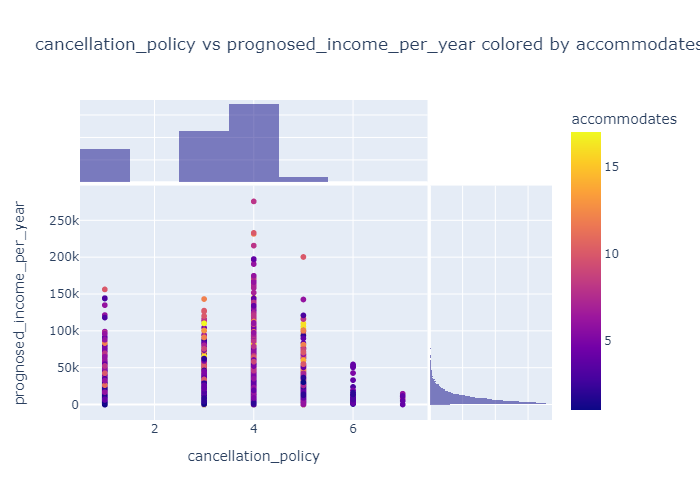

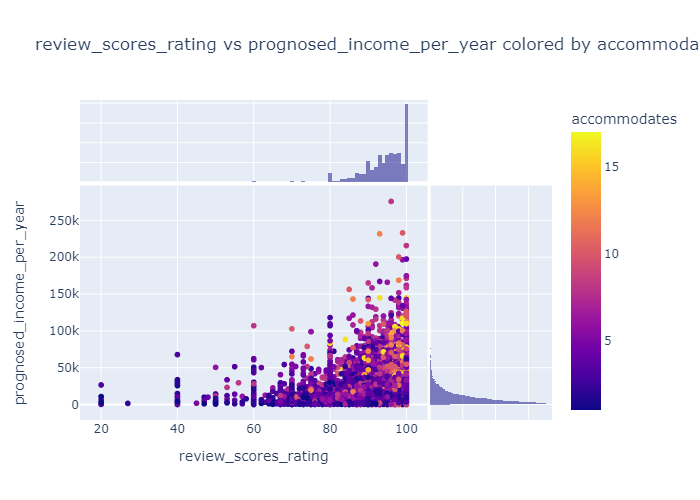

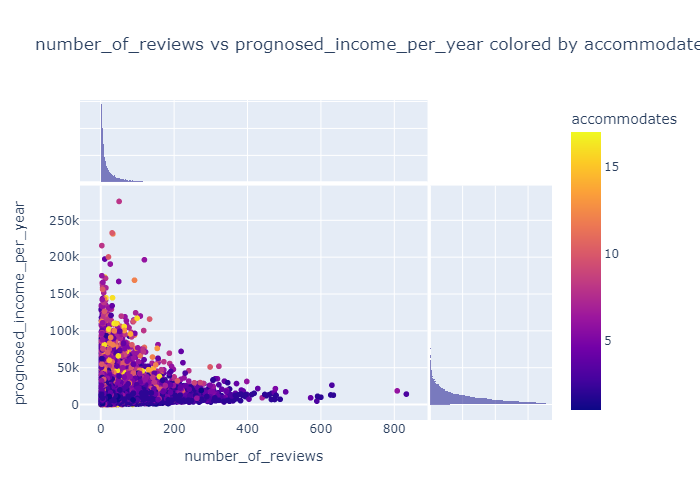

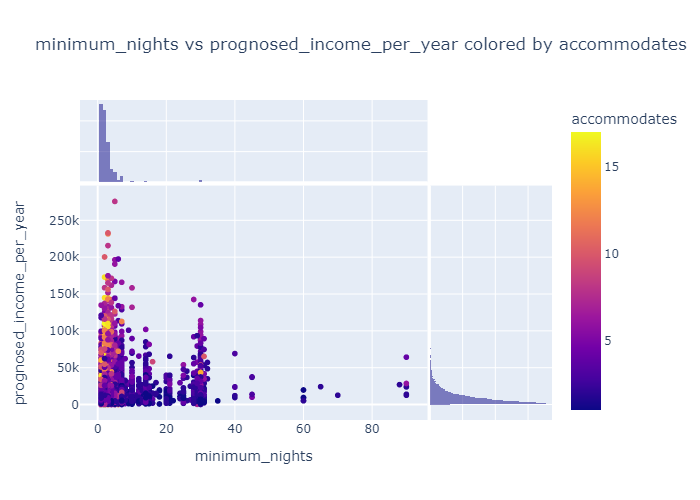

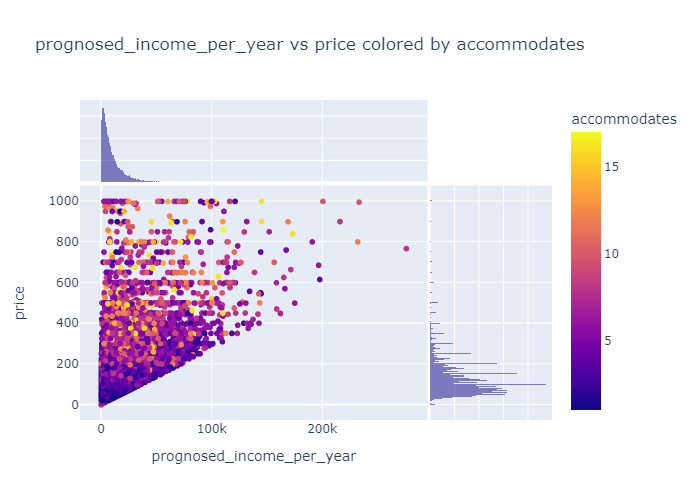

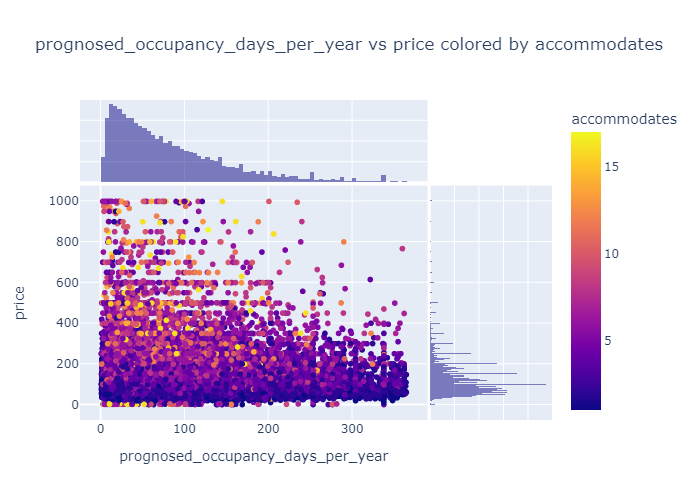

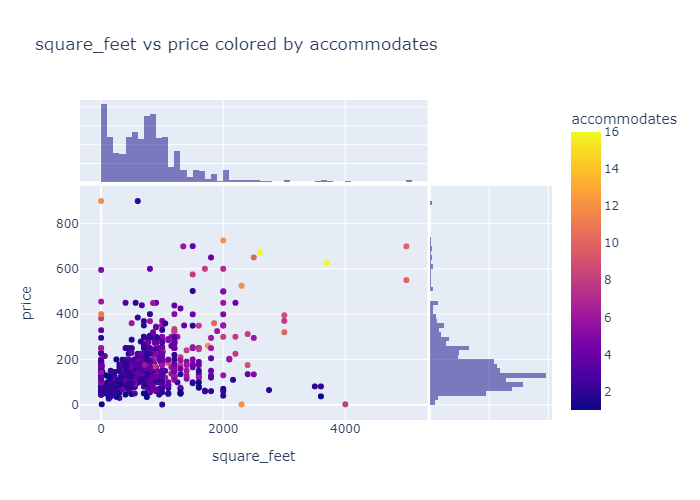

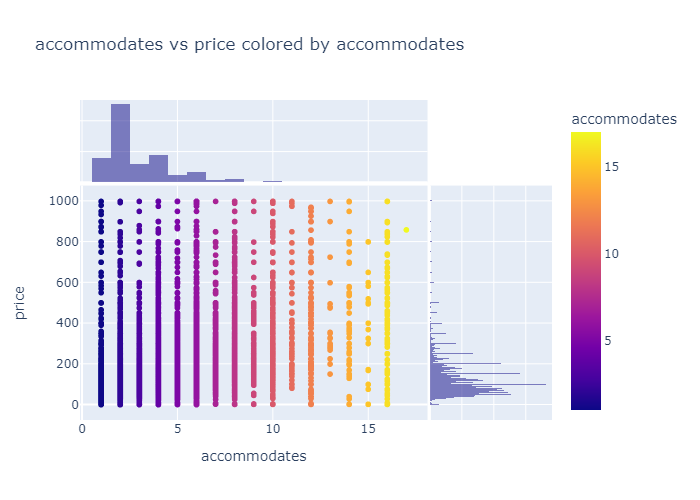

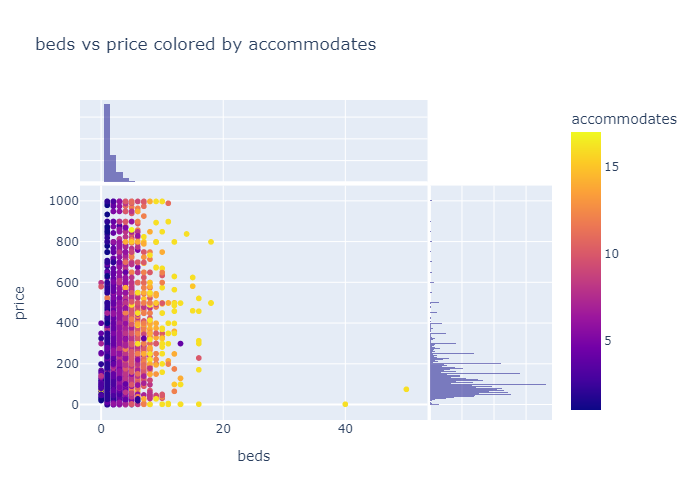

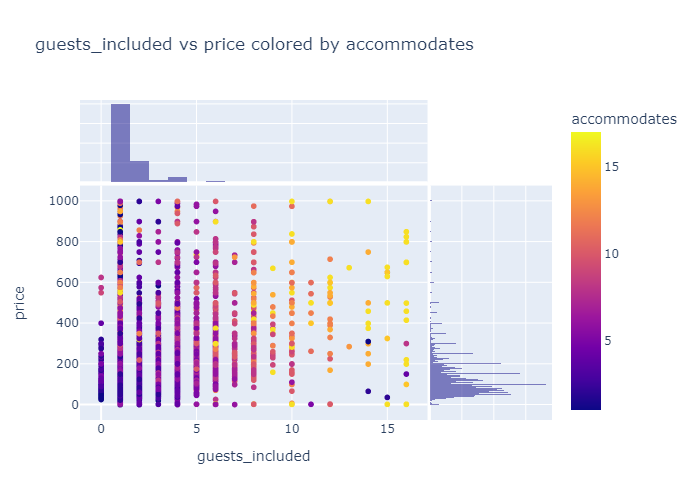

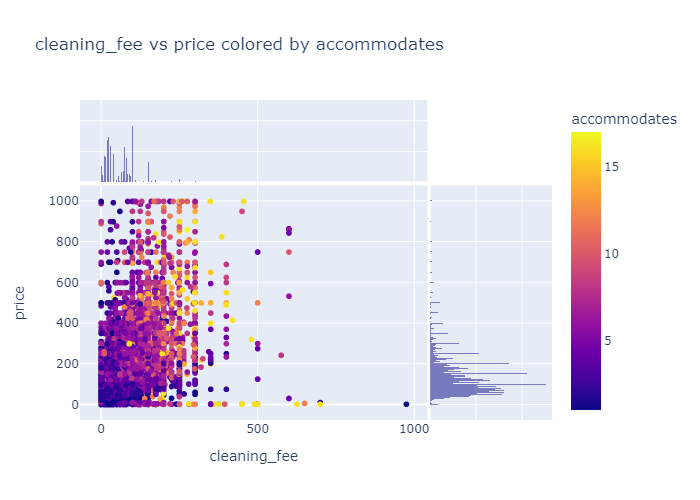

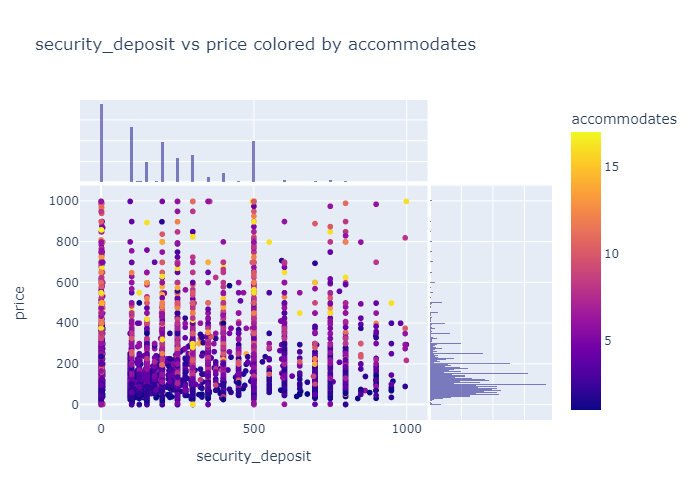

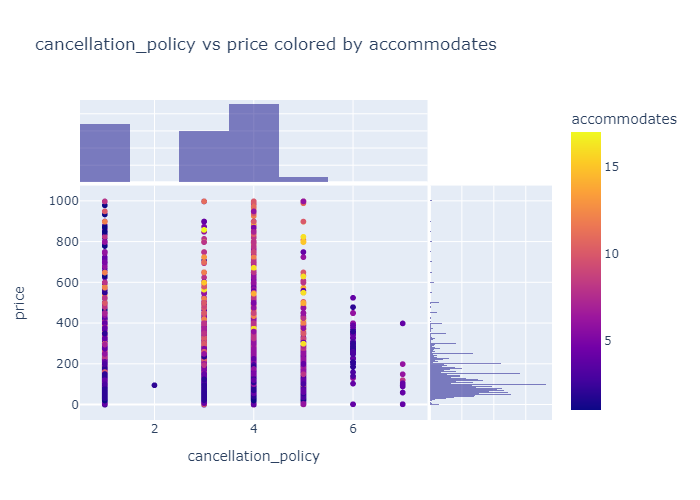

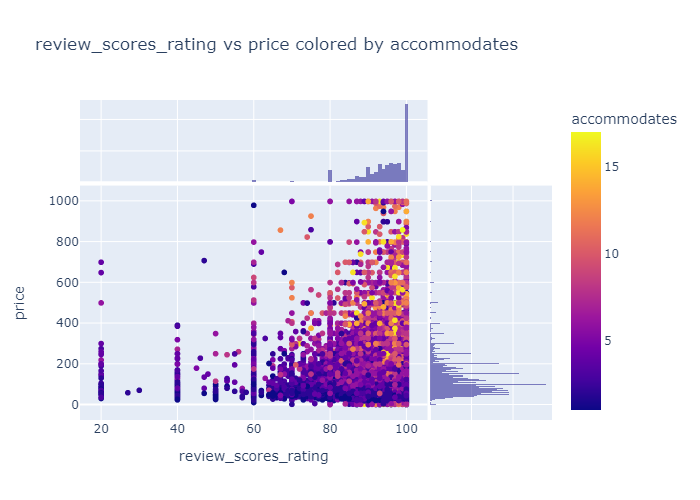

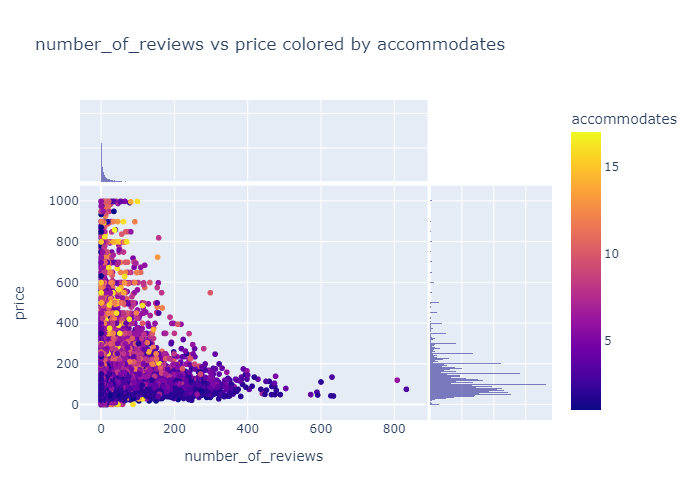

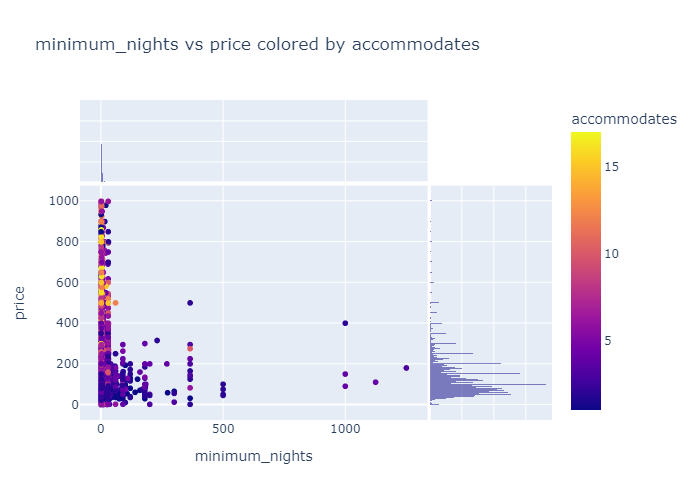

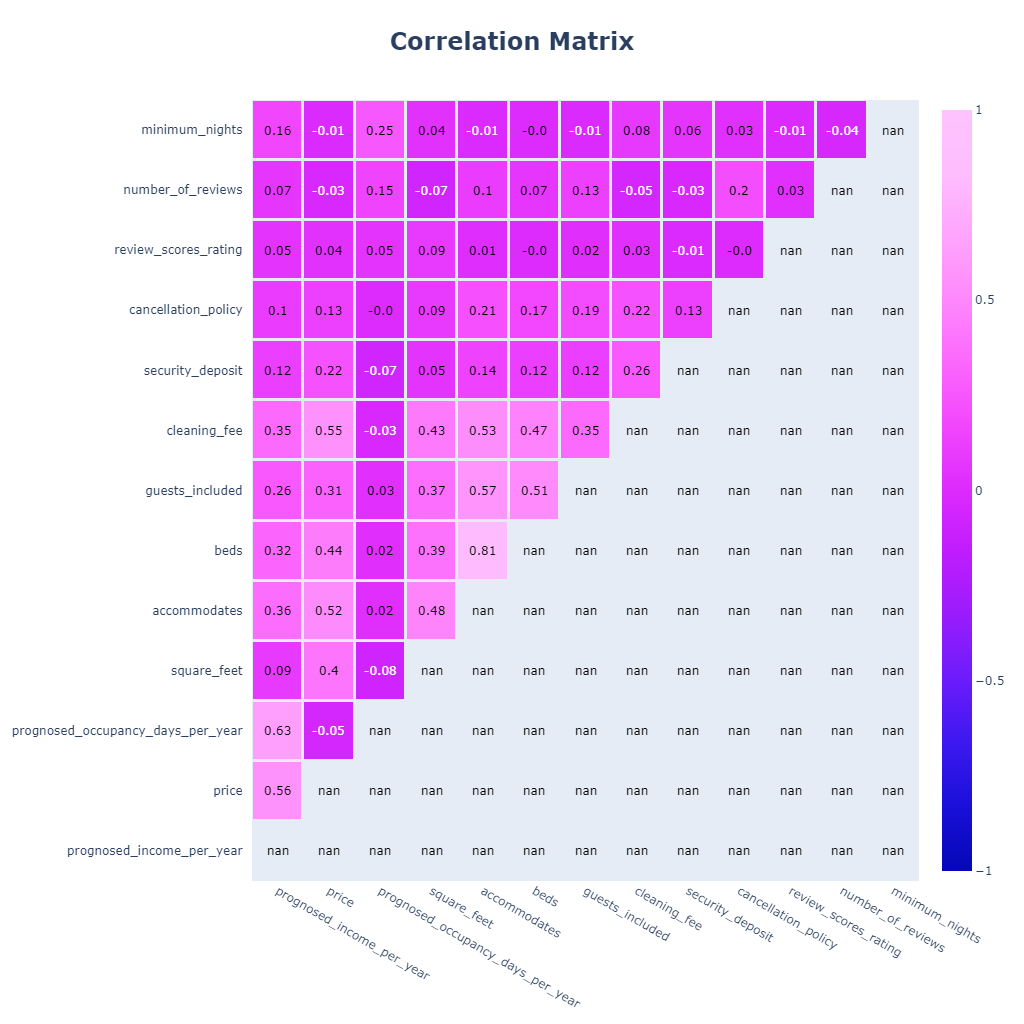

Выводы по итогам визуализации ключевых фичей:- очевидна прямая зависимость между ценой аренды в день, прогнозной загрузкой в днях в год объекта и прогнозным доходом в год;- также же есть прямая зависимость между коммунальными платежами за чистку помещения, количеством размещаемых арендаторов и прогнозным доходом в год;- видна прямая зависимость между ценой аренды в сутки, площадью и количеством кроватей, размещаемых арендаторов, коммунальными платежами за уборку;- самая высокая прямая зависимость - между числом арендаторов и количеством кроватей, количеством возможных костей и коммунальными платежами за уборку.
Баланс целевого признака до очистки в процессе очистки основного датасета: 

Количество уникальных значений целевого признака:  654


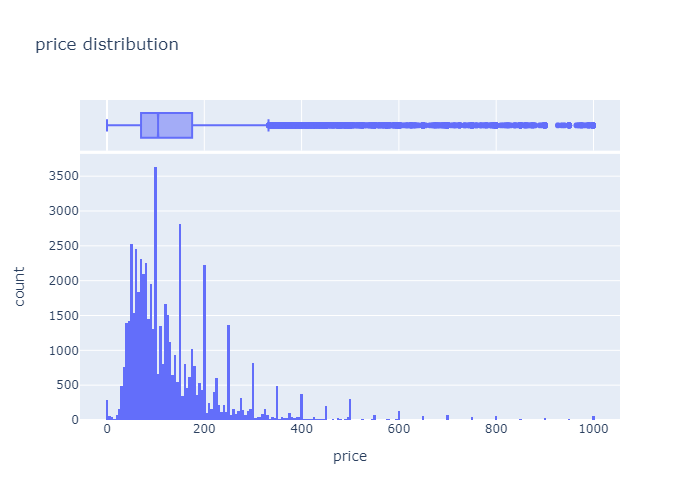



До очистки от NaN значений в процессе очистки основного датасета: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56585 entries, 0 to 56584
Data columns (total 93 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   id                                            int64  
 1   listing_url                                   object 
 2   last_scraped                                  object 
 3   name                                          object 
 4   summary                                       object 
 5   space                                         object 
 6   description                                   object 
 7   experiences_offered                           object 
 8   neighborhood_overview                         object 
 9   notes                                         object 
 10  transit                                       object 
 11  access                                        obj

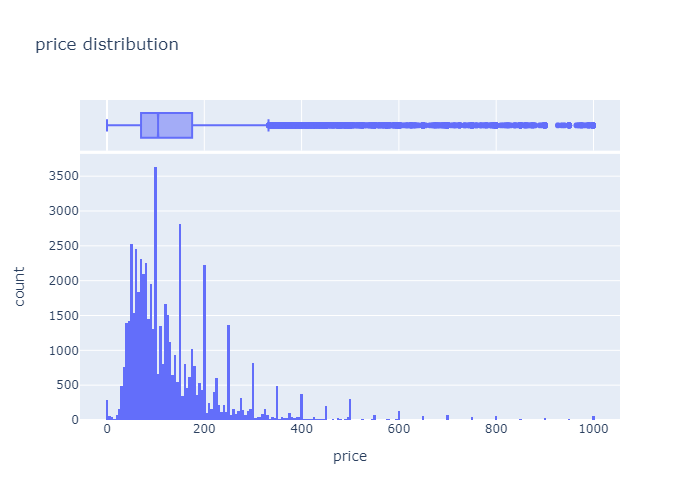





После генерации нового признака для исходного датафрейма: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56585 entries, 0 to 56584
Data columns (total 89 columns):
 #   Column                                        Dtype         
---  ------                                        -----         
 0   id                                            int64         
 1   last_scraped                                  datetime64[ns]
 2   name                                          object        
 3   summary                                       object        
 4   space                                         object        
 5   description                                   object        
 6   experiences_offered                           object        
 7   neighborhood_overview                         object        
 8   notes                                         object        
 9   transit                                       object        
 10  access                        

In [2]:
# настроим отображение при выводе в консоль
set_up_printing()

# считаем данные и одновременно удалим пустые строки
dataframe = pd.read_csv(r'C:\Users\kM\Desktop\MIPT\dataton\boston_ny_seattle_denver_airbnb.csv',
                        skip_blank_lines=True)

# важные семантически столбцы с точки зрения доменной области, при прочих равных (например, высокая парная корреляция
# с другим признаком, не входящим в список) будут сохранены
columns_with_high_semantic_value = ['id', 'last_scraped', 'price', 'description', 'house_rules',
                                    'neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type',
                                    'accommodates', 'bedrooms', 'beds', 'bed_type', 'amenities', 'minimum_nights',
                                    'availability_365', 'cleaning_fee', 'security_deposit', 'guests_included',
                                    'extra_people', 'number_of_reviews', 'first_review', 'last_review',
                                    'review_scores_rating', 'reviews_per_month', 'cancellation_policy', 'df_city',
                                    'prognosed_occupancy_days_per_year', 'prognosed_income_per_year']

# для анализ зависимостей, создадим новый датасет на основе очистки исходного
dataframe_for_initial_matrix_correlation = clear(dataframe, columns_with_high_semantic_value,
                                                 is_initial_analysis=True)

# для анализ зависимостей, преобразуем качественные признаки к количественным
dataframe_for_initial_matrix_correlation = one_to_one_transforms(dataframe_for_initial_matrix_correlation,
                                                                 is_initial_analysis=True)
dataframe_for_initial_matrix_correlation = one_to_many_transform(dataframe_for_initial_matrix_correlation,
                                                                 is_initial_analysis=True)

# сдеаем корреляционный анализ
dataframe_for_initial_matrix_correlation, features_to_drop = correlation_matrix_analysis(
    dataframe_for_initial_matrix_correlation, columns_with_high_semantic_value)

features = ['prognosed_income_per_year', 'price', 'prognosed_occupancy_days_per_year', 'square_feet',
            'accommodates', 'beds', 'guests_included', 'cleaning_fee', 'security_deposit',
            'cancellation_policy', 'review_scores_rating', 'number_of_reviews', 'minimum_nights']
targets = ['prognosed_income_per_year', 'price']

# визуализация
draw_visualization(dataframe_for_initial_matrix_correlation, features, targets, 'accommodates')

print('Выводы по итогам визуализации ключевых фичей:'
      '- очевидна прямая зависимость между ценой аренды в день, прогнозной загрузкой в днях в год объекта'
      ' и прогнозным доходом в год;'
      '- также же есть прямая зависимость между коммунальными платежами за чистку помещения, количеством'
      ' размещаемых арендаторов и прогнозным доходом в год;'
      '- видна прямая зависимость между ценой аренды в сутки, площадью и количеством кроватей,'
      ' размещаемых арендаторов, коммунальными платежами за уборку;'
      '- самая высокая прямая зависимость - между числом арендаторов и количеством кроватей, количеством'
      ' возможных костей и коммунальными платежами за уборку.')

dataframe_for_initial_matrix_correlation.to_csv(
    r'C:\Users\kM\Desktop\MIPT\dataton\boston_ny_seattle_denver_airbnb_dropped_uninformative_features_minimum_transformations_for_visualization.csv',
    index=False)

# очистим исходных набор от кросс-скоррелированных признаков
dataframe = dataframe.drop(features_to_drop, errors='ignore', axis=1)

# очистим исходный датасет от неинформативных признаков, после корреляционного анализа
dataframe = clear(dataframe, columns_with_high_semantic_value)
# сделаем лишь минимальную трансформацию, в отличие от проведенной при радведочном анализе
dataframe = one_to_one_transforms(dataframe, is_minimum_transform=True)
dataframe = one_to_many_transform(dataframe)

# запишем обработанный датасет в файл
dataframe.to_csv(
    r'C:\Users\kM\Desktop\MIPT\dataton\boston_ny_seattle_denver_airbnb_dropped_uninformative_features.csv',
    index=False)